In [1]:
import xarray as xr
import xroms
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import cmocean.cm as cmo
import cf_xarray
import xcmocean
import RePlots as rp
from glob import glob

In [2]:
# where on Ada cartopy can access data for plotting on maps like coastline data
# on a personal computer this just happens in the background and is downloaded 
# in the background and found in a consistent location, but on Ada the nodes are not
# connected to the internet.
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'

# Read in model output

`glob` finds file names follow patterns. In the following, the files that match the set pattern are returned, where the "\*" is a wildcard. In this case, all files from 2017 are returned.

The files are then loaded into Python using `xroms` which wraps the basic functionality in `xarray`. The result is an xarray Dataset of the model output. Chunks are used to break up the model output for use by `dask`. In this case, only the time dimension is being chunked, in order to avoid needing to rechunk later.

In [6]:
# files = glob('/ihesp/user/liu6/GOM_9k_nature_copernicus/Orig/*')
# files = glob('/ihesp/user/liu6/GOM_9k_nature_copernicus/Orig/GOM*.ocn.hi.????-*.nc')
files = glob('/ihesp/user/liu6/GOM_9k_nature_copernicus/Orig/GOM*.ocn.hi.2017-*.nc')
files.sort()
ds = xroms.open_mfnetcdf(files, chunks={'ocean_time': 30})

In [38]:
#set up plotting projections stuff for maps
pc = cartopy.crs.PlateCarree()  # to match lon/lat
proj = cartopy.crs.LambertConformal(central_longitude=-90)  # projection for plot

# Calculations to plot

Here we run several calculations. 

## SST anomaly longitude slice

### Select surface temperature

Select the surface temperature only. The `drop` keyword argument drops the coordinate, `s_rho`, in the "z" direction, rather than bringing it along, which helps `cf-xarray` to properly track the coordinates and dimensions present in the array. You can learn more about the `drop` keyword by reading the relevant by running the command

    ds.isel?
    
Here I used the `cf-xarray` accessor for convenience to refer to the Z dimension rather than specifying the "s_rho" dimension. I could avoid using the `cf-xarray` accessor and get the same result with

    ds.temp.isel(s_rho=-1, drop=True)
    
Note that the "-1" is used in this index selection approach to pull out the final index in the s_rho dimension, which is how to access the surface. You can learn more about subselecting by time and space by both index (`isel`) and keyword (`sel`) in [xarray docs](http://xarray.pydata.org/en/stable/indexing.html) or in xroms [select_data notebook](https://github.com/kthyng/xroms/blob/master/examples/select_data.ipynb).

In [20]:
# Select the surface 
sst = ds.temp.cf.isel(Z=-1, drop=True)

### Calculate slice of surface temperature at -86 longitude

`isoslice` in `xroms` wraps the `transform` function in `xgcm` to calculate an isosurface of an array at a particular value. So, the following calculates the surface temperature (`sst`) in the `X` (same as "xi" same as "longitude") direction projected to the `lon_rho` array at the value of -86 longitude:

In [21]:
sst_slice = sst.xroms.isoslice(-86, ds.temp.lon_rho, axis='X')

### Calculate the mean SST over time

Calculate the mean of SST over the dataset. The `skipna` keyword argument suppresses a warning for locations that has all nan's, such as masked cells in the model.

In [22]:
sst_slice_mean = sst_slice.cf.mean('T', skipna=False)

### Calculate the anomaly by day of year

Here we:
* Calculate the SST anomaly at this longitude
* Group the anomaly values by the day of the year across the available years. In this case, there is only one year included but the calculation is setup the same. If not using `cf-xarray`, the second line would be: `anom.groupby("ocean_time.dayofyear").mean(skipna=False)`. After the `groupby` part of the line, an aggregation function needs to be used for the grouping; in this case we choose to take the mean over the values grouped by the day of the year (other options would be e.g. max, min, etc).
* `hov.cf.guess_coord_axis()` is used to add back in some attributes to help `cf-xarray` work better.

In [29]:
anom = (sst_slice - sst_slice_mean)
hov = anom.cf.groupby("T.dayofyear").mean(skipna=False)
hov = hov.cf.guess_coord_axis()

### Run computation

Up to this point, all of the calculations have been lazily evaluated.

In [34]:
hov = hov.compute()

## Eddy kinetic energy

This calculation is done in `xroms`. The details are available by running `xroms.EKE?` in a cell.

* Use calculation for EKE built into xroms using the xroms accessor (`ds.xroms.EKE`)
* Calculate the mean of EKE over time (`.cf.mean('T', skipna=False)`)
* Run the computation and save the numbers (`.compute()`)

In [35]:
EKE = ds.xroms.EKE.cf.mean('T', skipna=False)
EKE = EKE.compute()

## Mean surface temperature

* Select the surface temperature (`ds.temp.cf.isel(Z=-1)`)
* Take the mean over time (`.cf.mean('T', skipna=False)`)
* Run computation (`.compute()`)

In [36]:
SST = ds.temp.cf.isel(Z=-1).cf.mean('T', skipna=False)
SST = SST.compute()

# Plots

Much of the code below is from either `matplotlib`, the Python plotting package, or `matplotlib` wrapped by `xarray`. The `rp.` functions are convenience functions I wrote in `RePlots` to make many of the plotting details easier/better.

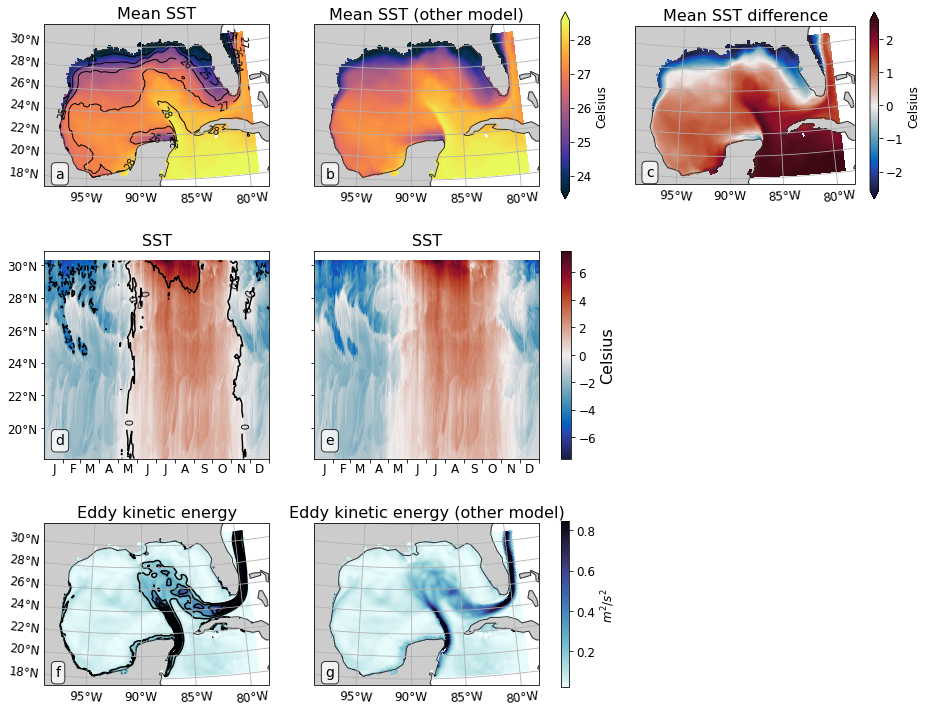

In [39]:
# set up figure with size
fig = plt.figure(figsize=(15,13))
# we will have 3 rows of plots and 3 columns of plots
nrows, ncols = 3, 3

titlesize = 16
ticksize = 12

## Mean SSTs ##
# set up subplot in location 1 (top left) with a projection since it is a map
ax1 = plt.subplot(nrows, ncols, 1, projection=proj)
# call the setup_map convenience function to get the basics into the map
# this returns a dictionary of items to input to your subsequent plotting calls
pargs, oargs = rp.setup_map(ax=ax1, title='Mean SST', titlesize=titlesize, xticks=np.arange(-95,-75,5),
                            ticklabelsize=ticksize, subargs={'label': 'a', 'loc': 'bottom left'})
# input plotting dictionary `pargs` into pcolormesh plot call with syntanx `**pargs` to unpack all items
# a basic xarray plot could happen with `SST.plot()` or equivalently in this case `SST.plot.pcolormesh()`
# also here using xcmocean accessor to choose colormap based on properties of the DataArray being plotted.
# also using cf-xarray accessor to be able to generally refer to longitude and latitude without referring to 
# specific grid.
SST.cmo.cfpcolormesh(**pargs)
# also plot contour lines on top. This is matplotlib wrapped by xarray with cf-xarray.
cs = SST.cf.plot.contour(**pargs, colors='k', linewidths=1)
# also label contour lines. This is matplotlib directly.
ax1.clabel(cs, inline=1, fontsize=10, fmt='%d')  # add labels to contours


ax2 = plt.subplot(nrows, ncols, 2, projection=proj)
pargs, oargs = rp.setup_map(ax=ax2, left_labels=False, title='Mean SST (other model)', titlesize=titlesize, 
                            ticklabelsize=ticksize, xticks=np.arange(-95,-75,5), 
                            subargs={'label': 'b', 'loc': 'bottom left'})
im = SST.cmo.cfplot(**pargs)
# Set up a colorbar with this convenience wrapper. Have it take space from both axes so far with `ax=[ax1,ax1]`.
rp.cbar(im, ax=[ax1,ax2], label='Celsius', labelsize='large', ticksize='large', extend='both', shrink=0.9)


ax3 = plt.subplot(nrows, ncols, 3, projection=proj)
pargs, oargs = rp.setup_map(ax=ax3, left_labels=False, title='Mean SST difference', titlesize=titlesize, 
                            ticklabelsize=ticksize, xticks=np.arange(-95,-75,5), 
                            subargs={'label': 'c', 'loc': 'bottom left'})  # making up new variable to show difference
im = (SST-26).cmo.cfplot(**pargs)
rp.cbar(im, ax=ax3, label='Celsius', labelsize='large', ticksize='large', extend='both', shrink=0.9, pad=0.06)


## Hovmoller ##
ax4 = plt.subplot(nrows, ncols, 4)
# setup plot but not a map. This is setup to nicely format based on plotting longitude, latitude, or time.
pargs, _ = rp.setup_hov(hov, ax4, xaxis='time', yaxis='lat', title='SST', titlesize=titlesize, 
                        ticklabelsize=ticksize, 
                        subargs={'label': 'd', 'loc': 'bottom left'})
hov.cmo.cfplot(**pargs)
cs = hov.squeeze().cmo.cfcontour(**pargs, levels=5, colors='k')
ax4.clabel(cs, inline=1, fontsize=10, fmt='%d')


ax5 = plt.subplot(nrows, ncols, 5)
pargs, _ = rp.setup_hov(hov, ax5, xaxis='time', yaxis='lat', xticklabels=True, yticklabels=False,
                  title='SST', titlesize=titlesize, ticklabelsize=ticksize, 
                  subargs={'label': 'e', 'loc': 'bottom left'})
im = hov.cmo.cfplot(**pargs)
rp.cbar(im, ax=[ax4,ax5], labelsize=16, label='Celsius', ticksize='large')


## EKE ##
ax7 = plt.subplot(nrows, ncols, 7, projection=proj)
pargs, oargs = rp.setup_map(ax=ax7, title='Eddy kinetic energy', titlesize=titlesize, xticks=np.arange(-95,-75,5),
                            ticklabelsize=ticksize, subargs={'label': 'f', 'loc': 'bottom left'})
EKE.cmo.cfplot(**pargs)
cs = EKE.cf.plot.contour(**pargs, colors='k')


ax8 = plt.subplot(nrows, ncols, 8, projection=proj)
pargs, oargs = rp.setup_map(ax=ax8, left_labels=False, title='Eddy kinetic energy (other model)', 
                            titlesize=titlesize, ticklabelsize=ticksize, 
                            xticks=np.arange(-95,-75,5), subargs={'label': 'g', 'loc': 'bottom left'})
im = EKE.cmo.cfplot(**pargs)
rp.cbar(im, ax=[ax7,ax8], label='$' + EKE.units +'$', shrink=0.8, labelsize='large', ticksize='large');
